Student: Martynas Jonkus   
Classes: Jellyfish, Owl, Pizza

In [17]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

In [2]:
from google.colab import drive

drive.mount('/content/drive')
drive_image_dir = "drive/MyDrive/OpenImages_GMM_1lab"
os.makedirs(drive_image_dir, exist_ok=True)

Mounted at /content/drive


In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for class_name in self.classes:
          class_dir = os.path.join(root_dir, class_name)
          if os.path.isdir(class_dir):
              for img_name in os.listdir(class_dir):
                  if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                      img_path = os.path.join(class_dir, img_name)
                      self.image_paths.append(img_path)
                      self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        label = self.labels[index]

        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Skipping corrupt image: {img_path}")
            return None

In [6]:
class Convolutional_Neural_Network(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        channels = [3, 32, 64, 128, 256]
        self.features = nn.Sequential()

        for i in range(len(channels)-1):
            self.features.add_module(f'conv_block{i+1}', nn.Sequential(
                nn.Conv2d(channels[i], channels[i+1], kernel_size=3, padding=1),
                nn.BatchNorm2d(channels[i+1]),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ))

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [7]:
def train_model(model, train_loader, device, epochs=10, lr=0.001, save_path='best_model.pth'):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {'loss': [], 'accuracy': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            # images shape is [batch_size, 3, 224, 224] containing RGB images of size 224x224
            # labels shape is [batch_size], example: tensor([0, 2, 1, 0, 2, ...])
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            # outputs shape is [batch_size, 3], example:
            # tensor([[ 0.1823, -0.5291,  1.2513],  # -> class 2
            #         [ 2.3410,  0.2931,  0.1020],  # -> class 0
            #         [-0.1820,  1.3291, -0.2513],  # -> class 1
            #         ...])
            outputs = model(images)

            # Compute loss
            # returns the average loss for all images in batch
            # loss shape is a single scalar, example: tensor(1.4382)
            loss = criterion(outputs, labels)

            # Clear the gradients
            optimizer.zero_grad()

            # Backward pass
            # computes gradient for each model parameter
            loss.backward()

            # Optimize
            # updates weights based on gradients, learning rate, and Adam's algorithm
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = correct / total

        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)

        print(f'Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}')


    torch.save(model.state_dict(), save_path)
    print(f'Training completed. Model saved to {save_path}')

    return model, history

In [8]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Calculate per-class metrics
    class_precision = precision_score(all_labels, all_preds, average=None)
    class_recall = recall_score(all_labels, all_preds, average=None)
    class_f1 = f1_score(all_labels, all_preds, average=None)

    # Create confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'class_precision': class_precision,
        'class_recall': class_recall,
        'class_f1': class_f1,
        'confusion_matrix': conf_matrix
    }

    return metrics

In [27]:
class TransformSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [31]:
def imshow(img, title=None):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

def display_batch(dataloader, dataset, num_images=8):
    images, labels = next(iter(dataloader))

    grid = torchvision.utils.make_grid(images[:num_images], nrow=4)

    plt.figure(figsize=(12, 6))
    imshow(grid)

    class_names = dataset.subset.dataset.classes
    label_names = [class_names[labels[i].item()] for i in range(num_images)]

    plt.title(f"Sample images: {', '.join(label_names)}")
    plt.show()

In [32]:
full_dataset = CustomDataset(root_dir="drive/MyDrive/OpenImages_GMM_1lab/train")
print(f"Total dataset size: {len(full_dataset)}")
print(f"Classes: {full_dataset.classes}")

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_subset, test_subset = random_split(full_dataset, [train_size, test_size])

train_dataset = TransformSubset(train_subset, train_transform)
test_dataset = TransformSubset(test_subset, test_transform)

print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Total dataset size: 999
Classes: ['jellyfish', 'owl', 'pizza']
Training set size: 799
Test set size: 200


Training data samples:


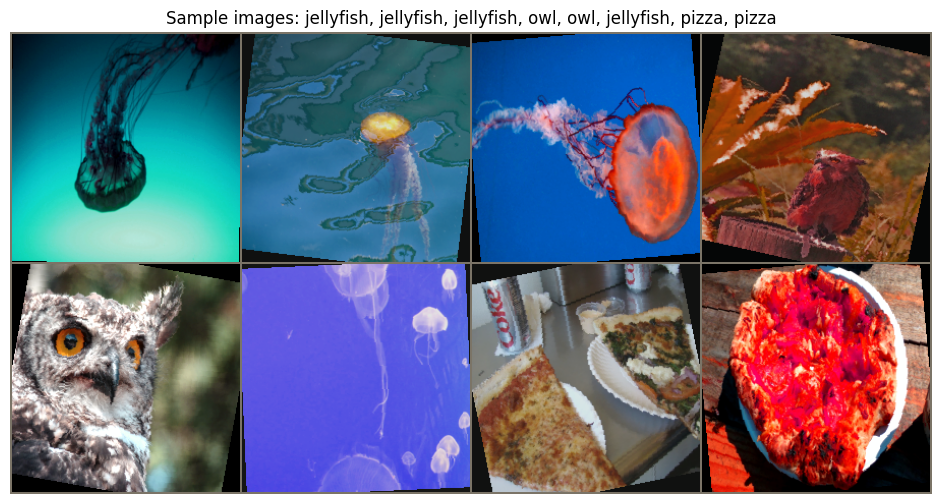

Test data samples:


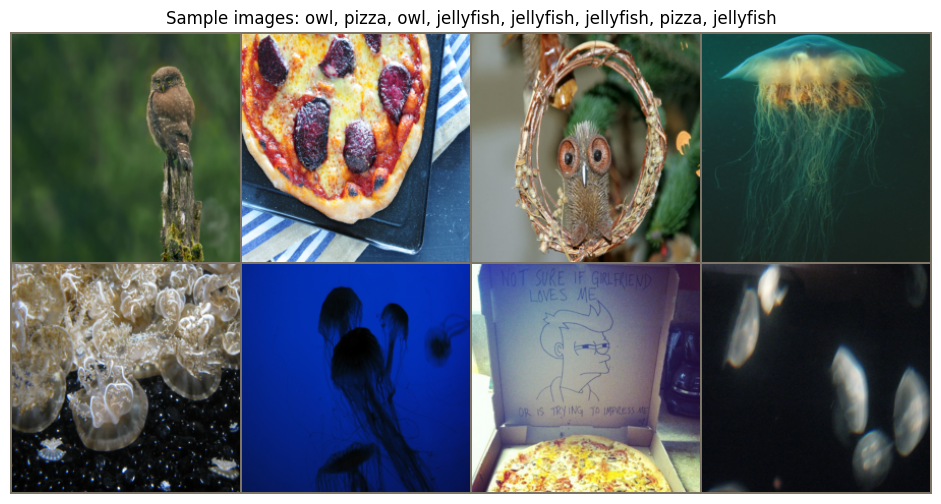

In [33]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Training data samples:")
display_batch(train_loader, train_dataset)

print("Test data samples:")
display_batch(test_loader, test_dataset)

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = Convolutional_Neural_Network(num_classes=len(full_dataset.classes))
model.to(device)
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Using device: cuda
Convolutional_Neural_Network(
  (features): Sequential(
    (conv_block1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding

In [35]:
trained_model, history = train_model(
    model=model,
    train_loader=train_loader,
    device=device,
    epochs=20,
    lr=0.001,
    save_path='drive/MyDrive/OpenImages_GMM_1lab/trained_model.pth'
)

Epoch 1/20 | Loss: 2.0524 | Accuracy: 0.6596
Epoch 2/20 | Loss: 0.9042 | Accuracy: 0.7084
Epoch 3/20 | Loss: 0.6572 | Accuracy: 0.7610
Epoch 4/20 | Loss: 0.5484 | Accuracy: 0.7847
Epoch 5/20 | Loss: 0.4904 | Accuracy: 0.8073
Epoch 6/20 | Loss: 0.4938 | Accuracy: 0.8148
Epoch 7/20 | Loss: 0.4591 | Accuracy: 0.8248
Epoch 8/20 | Loss: 0.4906 | Accuracy: 0.8098
Epoch 9/20 | Loss: 0.4689 | Accuracy: 0.8110
Epoch 10/20 | Loss: 0.4613 | Accuracy: 0.8273
Epoch 11/20 | Loss: 0.4398 | Accuracy: 0.8373
Epoch 12/20 | Loss: 0.4392 | Accuracy: 0.8348
Epoch 13/20 | Loss: 0.4124 | Accuracy: 0.8373
Epoch 14/20 | Loss: 0.3863 | Accuracy: 0.8498
Epoch 15/20 | Loss: 0.3788 | Accuracy: 0.8648
Epoch 16/20 | Loss: 0.4370 | Accuracy: 0.8323
Epoch 17/20 | Loss: 0.3585 | Accuracy: 0.8548
Epoch 18/20 | Loss: 0.3728 | Accuracy: 0.8598
Epoch 19/20 | Loss: 0.3576 | Accuracy: 0.8523
Epoch 20/20 | Loss: 0.3790 | Accuracy: 0.8523
Training completed. Model saved to drive/MyDrive/OpenImages_GMM_1lab/trained_model.pth


In [36]:
metrics = evaluate_model(trained_model, test_loader, device)

Accuracy: 0.8350
Precision: 0.8694
Recall: 0.8350
F1 Score: 0.8358

Class: jellyfish
Precision: 1.0000
Recall: 0.7941
F1 Score: 0.8852

Class: owl
Precision: 0.9020
Recall: 0.7077
F1 Score: 0.7931

Class: pizza
Precision: 0.7053
Recall: 1.0000
F1 Score: 0.8272


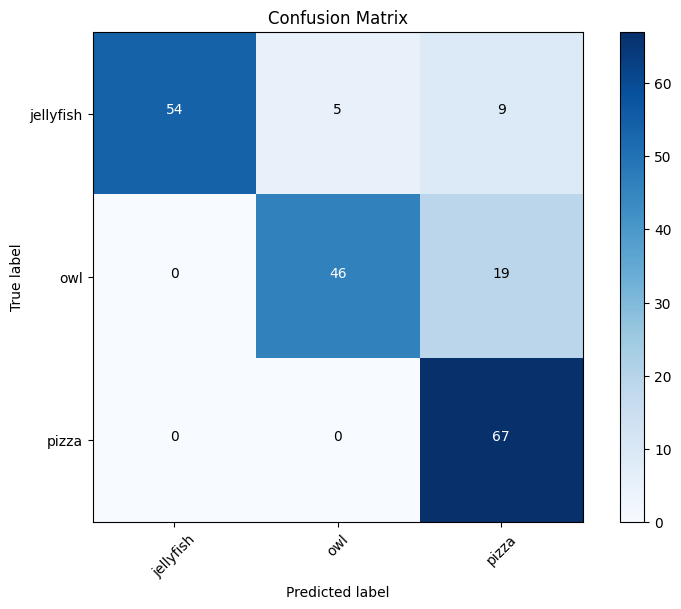

In [37]:
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1']:.4f}")

# Display class-specific metrics
for i, class_name in enumerate(full_dataset.classes):
    print(f"\nClass: {class_name}")
    print(f"Precision: {metrics['class_precision'][i]:.4f}")
    print(f"Recall: {metrics['class_recall'][i]:.4f}")
    print(f"F1 Score: {metrics['class_f1'][i]:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
cm = metrics['confusion_matrix']
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(full_dataset.classes))
plt.xticks(tick_marks, full_dataset.classes, rotation=45)
plt.yticks(tick_marks, full_dataset.classes)

# Add text annotations to the confusion matrix
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()